<a href="https://colab.research.google.com/github/tools-only/fastai/blob/master/lesson2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast.ai学习笔记： Lesson2 - Data cleaning and production；SGD from scratch

## Part 1： 利用Google Images创建自己的数据集
课程中选择了三种动物类别，分别是"teddy bear"、"black bear"和"grizzly bear"，在Google Images分别搜索这三个关键词，我使用的是Chrome浏览器，F12调出Chrome开发者工具，在Console控制台命令行输入课程中给定的JS代码：  
**urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);   
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n'))); **    
浏览器将会下载这些图片的url地址，将下载文件保存为.txt格式即可。


In [0]:
from fastai.vision import *

## 下载文件
需要将上一步下载下来的.txt文件上传到对应的文件目录下，以"teddy bear"为例，我这里使用的Google Colab目录为：data/bears/teddys，因此需要将teddy bear.txt文件上传到teddys文件夹中。


In [7]:
folders = ['black', 'teddys', 'grizzly']
files = ['black bear.txt', 'teddy bear.txt', 'grizzly bear.txt']
for i in range(3):
    folder = folders[i]
    file = files[i]
    path = Path('data/bears')
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)
    download_images(dest/file, dest, max_pics = 200, max_workers=0)
    

Error https://www.washingtonpost.com/resizer/3XR_4pCQML_c_PWsg5ByKcFsJow=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/AUEKO7HTGII6RGOCZ7FG7T3BBQ.jpg HTTPSConnectionPool(host='www.washingtonpost.com', port=443): Read timed out. (read timeout=4)
Error https://www.indianz.com/News/2017/06/30/yellowstonegrizzlycub.jpg ('Connection aborted.', OSError(0, 'Error'))


接下来需要删除无法打开的.jpg图片

In [8]:
for c in folders:
  print(c)
  verify_images(path/c, delete=True, max_size=500)

black


cannot identify image file <_io.BufferedReader name='data/bears/black/00000007.jpg'>
Image data/bears/black/00000073.png has 4 instead of 3 channels
cannot identify image file <_io.BufferedReader name='data/bears/black/00000094.jpg'>
Image data/bears/black/00000003.gif has 1 instead of 3 channels
cannot identify image file <_io.BufferedReader name='data/bears/black/00000016.jpg'>
teddys


cannot identify image file <_io.BufferedReader name='data/bears/teddys/00000009.jpg'>
Image data/bears/teddys/00000099.png has 4 instead of 3 channels
cannot identify image file <_io.BufferedReader name='data/bears/teddys/00000025.jpg'>
Image data/bears/teddys/00000016.png has 4 instead of 3 channels
Image data/bears/teddys/00000085.gif has 1 instead of 3 channels
Image data/bears/teddys/00000045.png has 4 instead of 3 channels
grizzly


cannot identify image file <_io.BufferedReader name='data/bears/grizzly/00000041.jpg'>
cannot identify image file <_io.BufferedReader name='data/bears/grizzly/00000058.jpg'>
cannot identify image file <_io.BufferedReader name='data/bears/grizzly/00000096.jpg'>
cannot identify image file <_io.BufferedReader name='data/bears/grizzly/00000079.jpg'>
cannot identify image file <_io.BufferedReader name='data/bears/grizzly/00000097.jpg'>


### 查看数据
由于数据集是在网上抓取的，所以这里需要手动设定train set和valid set，我们设定train set为当前文件夹中的数据，随机选取20%的图像作为valid set。

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
          ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [10]:
data

ImageDataBunch;

Train: LabelList (224 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
grizzly,grizzly,grizzly,grizzly,grizzly
Path: data/bears;

Valid: LabelList (56 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
grizzly,black,teddys,teddys,black
Path: data/bears;

Test: None

In [11]:
data.classes

['black', 'grizzly', 'teddys']

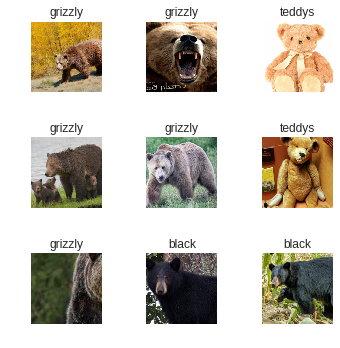

In [12]:
data.show_batch(rows=3, figsize=(5,5))

In [53]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['black', 'grizzly', 'teddys'], 3, 224, 56)

### 数据集分析
共三个类别，train set大小为224，valid set大小为56

In [54]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 54026164.63it/s]


In [55]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.414848,0.361477,0.125000
2,0.873345,0.098366,0.035714
3,0.592607,0.090661,0.017857
4,0.461319,0.091769,0.017857


可以看到效果还是不错的

In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


学习LR：我们需要寻找loss下降持续最长的区间，如下图中的[1e-05, 1e-03]

Min numerical gradient: 1.20E-05


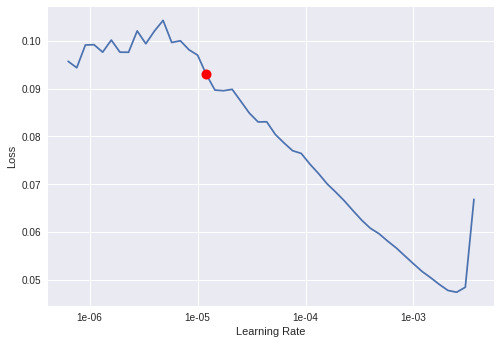

In [0]:
learn.recorder.plot()

选择loss下降比较稳定的lr区间

In [0]:
learn.fit_one_cycle(2, max_lr=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.011063,0.036405,0.035714
2,0.014576,0.039332,0.017857


In [0]:
learn.save('stage-2')

## 结果分析

In [0]:
learn.load('stage-2')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

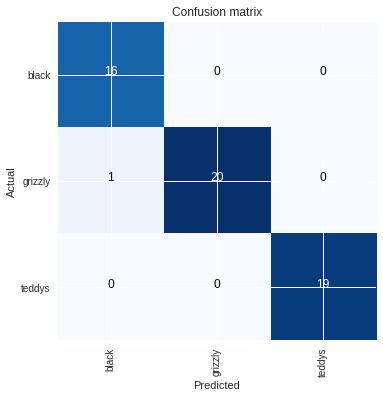

In [0]:
interp.plot_confusion_matrix()

可以看到预测错误的项，如模型将3张black bear图像错误地预测为grizzly bear

## 数据清洗

In [0]:
from fastai.widgets import *

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

In [0]:
ImageCleaner(ds, idxs, path)

In [0]:
ds, idx = DatasetFormatter().from_similars(learn, ds_type=DatasetType.Valid)

Getting activations...


Computing similarities...


In [0]:
ImageCleaner(ds, idx, path, duplicates=True)

In [0]:
learn.export()

将处理器切换为CPU，并选取black路径中的一张黑熊图像

In [0]:
defaults.device = torch.device('cpu')

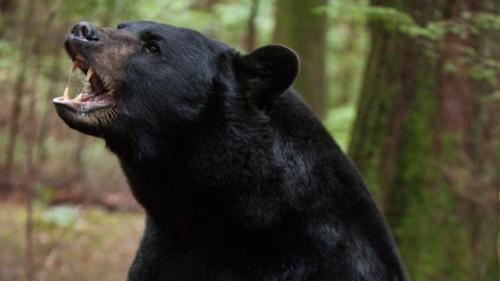

In [61]:
img = open_image(path/'black'/'00000021.jpg')
img

In [0]:
learn = load_learner(path)

看一看模型对这张图片的预测情况

In [63]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

Category black

接下来课程中讲述了在模型训练阶段最重要的两个参数，LR以及epochs。并分别阐述了这两个参数如何调优的方法。  
首先来看LR过高的情况

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [65]:
learn.fit_one_cycle(1, max_lr=0.5)

epoch,train_loss,valid_loss,error_rate
1,5.011953,20753188.000000,0.660714


这里设置LR=0.5，相比我们上一步中设置的1e-04来说要大非常多，最后的结果也表明了error_rate变大了许多。  
那么LR太小的情况呢？

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [67]:
learn.fit_one_cycle(5, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate
1,1.745538,1.565813,0.821429
2,1.715537,1.470828,0.839286
3,1.683431,1.416979,0.857143
4,1.671349,1.389117,0.821429
5,1.682199,1.383078,0.767857


对比default LR的训练过程，可以看到当lr过小时，error_rate下降很缓慢。与此同时，可以看到train_loss要比valid_loss大，这说明模型训练得不够，也就是欠拟合。


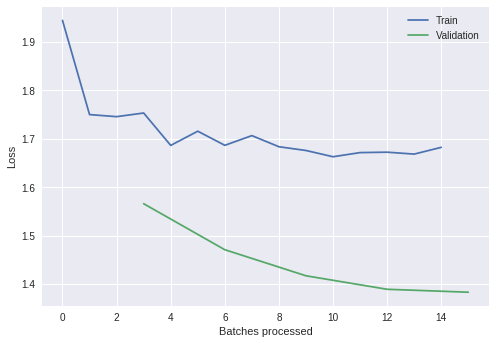

In [68]:
learn.recorder.plot_losses()

如果过少的epoch呢？  
可以想象如果epoch设置太小，可能模型会欠拟合

In [98]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, pretrained=False)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,1.394500,23.106329,0.660714


In [99]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,1.062521,0.208137,0.107143


In [100]:
learn = create_cnn(data, models.alexnet, metrics=error_rate, pretrained=False)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,1.272550,1.083349,0.553571


In [101]:
learn = create_cnn(data, models.alexnet, metrics=error_rate)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,1.210231,0.516949,0.303571


按照课程里的说明，这里应该出现train_loss大于valid_loss的情况，也就是模型欠拟合通常的标志。但是我在实验时出现了train_loss远小于valid_loss的情况，而error_rate相比默认设定下的模型又要大一些。20190223更新：我尝试了不同的模型，发现预训练模型的结果更为合理一些，原因待查明。

epoch设置太大，可能导致模型过拟合

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=28, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

第一次划分数据集的时候，由于bs设置为32，而train set实际只分到28张图像，因此会报错。将bs调整后能正常运行。

In [0]:
learn = create_cnn(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

In [0]:
learn.fit_one_cycle(40, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate
1,1.136135,1.198659,0.642857
2,1.136374,1.175168,0.650794
3,1.142848,1.148121,0.615079
4,1.126008,1.113956,0.599206
5,1.077778,1.065885,0.555556
6,1.015459,1.005064,0.496032
7,0.951661,0.932859,0.400794
8,0.876532,0.848827,0.305556
9,0.802810,0.762878,0.222222
10,0.733508,0.679503,0.182540


通过结果可以看到，随着epoch的增加，train_loss一直在减少，但error_rate却在减少一段时间后开始变大(振荡)，这通常标志着模型过拟合。